In [1]:
require 'paths'

function loadDataSet(trainSize, testSize)
    local trainSetSize = trainSize
    local testSetSize = testSize

    local trainFile = paths.concat('data/mnist.t7/', 'train_32x32.t7')
    local trainSet = torch.load(trainFile, 'ascii')
    trainSet.data = trainSet.data:double()
    trainSet.data = trainSet.data[{{1, trainSetSize}, {}, {}, {}}]
    trainSet.labels = trainSet.labels:double()
    trainSet.labels = trainSet.labels[{{1, trainSetSize}}]


    local testFile = paths.concat('data/mnist.t7/', 'test_32x32.t7')
    local testSet = torch.load(testFile, 'ascii')
    testSet.data = testSet.data:double()
    testSet.data = testSet.data[{{1, testSetSize},{},{},{}}]
    testSet.labels = testSet.labels:double()
    testSet.labels = testSet.labels[{{1, testSetSize}}]

    ---- normalize training data
    local mean = trainSet.data[{ {}, {1}, {}, {}  }]:mean()
    trainSet.data[{ {}, {1}, {}, {}  }]:add(-mean)
    local stdv = trainSet.data[{ {}, {1}, {}, {}  }]:std() -- std estimation
    trainSet.data[{ {}, {1}, {}, {}  }]:div(stdv)

    ---- normalize test data
    mean = testSet.data[{ {}, {1}, {}, {}  }]:mean()
    testSet.data[{ {}, {1}, {}, {}  }]:add(-mean)
    stdv = testSet.data[{ {}, {1}, {}, {}  }]:std()
    testSet.data[{ {}, {1}, {}, {}  }]:div(stdv)

    return {trainSet, testSet}
end

In [2]:
require 'nn';

In [3]:
local trainSize = 600
local testSize = 100
local datasets = loadDataSet(trainSize, testSize)
trainSet = datasets[1]
testSet = datasets[2]

In [4]:
trainSet

{
  data : DoubleTensor - size: 600x1x32x32
  labels : DoubleTensor - size: 600
}


In [5]:
testSet

{
  data : DoubleTensor - size: 100x1x32x32
  labels : DoubleTensor - size: 100
}


In [6]:
trainSet.labels = trainSet.labels - 1
testSet.labels = testSet.labels - 1

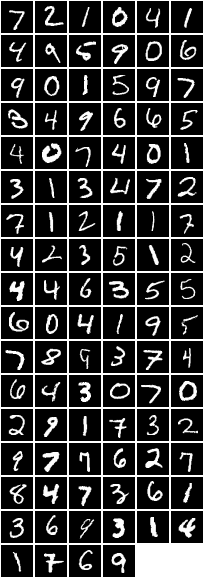

In [7]:
itorch.image(testSet.data)

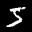

In [8]:
itorch.image(trainSet.data[1])

In [9]:
trainSet.labels[1]

5	


In [10]:
---- # of input channels of image
local input_channel = 1
---- # of output classes
local outputs = 10

-- Configure model network
model = nn.Sequential()
---- First convloution layer
------ 1 channel, 6 output channels, 5x5 convolution kernel
model:add(nn.SpatialConvolution(input_channel, 6, 5, 5))
model:add(nn.ReLU())
------ A max-pooling operation that looks at 2x2 windows and finds the max.
model:add(nn.SpatialMaxPooling(2,2,2,2))
---- Second convloution layer
------ 6 channels, 16 output channels, 5x5 convolution kernel
model:add(nn.SpatialConvolution(6, 16, 5, 5))
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2,2,2,2))
---- First fully connected layer
------ reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
model:add(nn.View(16*5*5))
model:add(nn.Linear(16*5*5, 120))
model:add(nn.ReLU())
---- Second fully connected layer
model:add(nn.Linear(120, 84))
model:add(nn.ReLU())
---- Gaussian layer 
model:add(nn.Linear(84, outputs))
model:add(nn.LogSoftMax())

In [13]:
-- Define loss function
loss = nn.ClassNLLCriterion()

In [14]:
-- Train the network
print("== start training")
local theta, gradTheta = model:getParameters()
local optimState = {learningRate = 0.01}

-- local maxIteration = 5
local maxIteration = 10
for epoch = 1, maxIteration do
    for i = 1, trainSet.data:size(1) do
        if (i % 100) == 0 then print(i) end
        gradTheta:zero()
        h_x = model:forward(trainSet.data[i])
        J = loss:forward(h_x, trainSet.labels[i])
        dJ_dh_x = loss:backward(h_x, trainSet.labels[i])
        -- Computes and updates gradTheta
        model:backward(trainSet.data[i], dJ_dh_x)
        model:updateParameters(optimState.learningRate)
    end
    -- For debugging only
    h_x = model:forward(trainSet.data)
    totalJ = loss:forward(h_x, trainSet.labels)
    print(string.format("current loss: %.5f", totalJ))
end
print("== end training")

== start training	


/root/torch/install/share/lua/5.1/nn/THNN.lua:110: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /root/torch/extra/nn/lib/THNN/generic/ClassNLLCriterion.c:48
stack traceback:
	[C]: in function 'v'
	/root/torch/install/share/lua/5.1/nn/THNN.lua:110: in function 'ClassNLLCriterion_updateOutput'
	/root/torch/install/share/lua/5.1/nn/ClassNLLCriterion.lua:41: in function 'forward'
	[string "-- Train the network..."]:13: in main chunk
	[C]: in function 'xpcall'
	/root/torch/install/share/lua/5.1/itorch/main.lua:210: in function </root/torch/install/share/lua/5.1/itorch/main.lua:174>
	/root/torch/install/share/lua/5.1/lzmq/poller.lua:80: in function 'poll'
	/root/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/root/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/root/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/root/torch/install/share/lua/5.1/itorch/main.lua:389: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00405d50: 